In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import PIL

### Load classes from imagenet.txt - [https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

In [2]:
with open('imagenet.txt') as f:
    image_classes = eval(f.read())

### Get feature and classification modules

In [29]:
module_classification = hub.Module(
    "https://tfhub.dev/google/imagenet/nasnet_large/classification/1")

In [7]:
module_features = hub.Module(
    "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1",
    trainable=True, tags={'train'}
)

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'.


In [5]:
height, width = hub.get_expected_image_size(module_classification)

In [6]:
print(height, width)

331 331


---

### Add Padding to image to fit desired height, width dimensions

In [13]:
def pad_image(image_, height_):
    # https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    desired_size = height_
    old_size = image_.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = image_.resize(new_size, PIL.Image.ANTIALIAS)

    # create a new image and paste the resized on it
    new_im = PIL.Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    
    return new_im

In [11]:
def load_prepare_image(fname):
    global height
    img = PIL.Image.open(fname)
    pad = pad_image(img, height)
    return tf.image.convert_image_dtype(pad, dtype=tf.float32)

In [9]:
image_files = ['cow.jpg', 'chicken.jpg']

In [14]:
images_tf = [load_prepare_image(fn) for fn in image_files]

---

In [25]:
NUM_CLASSES = 1000
features = module_features(images_tf)
logits = tf.layers.dense(features, NUM_CLASSES)
probabilities = tf.nn.softmax(logits)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [26]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    probs = sess.run(probabilities)

In [27]:
probs.shape

(2, 1000)

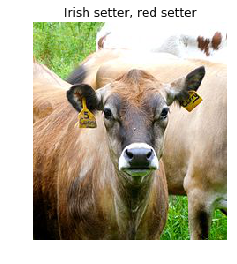

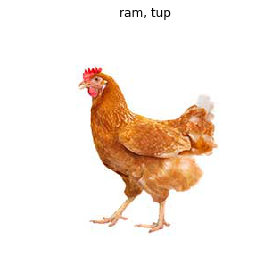

In [28]:
for i, prob in enumerate(probs):
    plt.figure()
    plt.imshow(PIL.Image.open(image_files[i]))
    plt.title(image_classes[np.argmax(prob)])
    plt.axis('off')

---

In [30]:
# Alternate module import
# module_spec = hub.load_module_spec("https://tfhub.dev/google/imagenet/nasnet_large/classification/1")
# height, width = hub.get_expected_image_size(module_spec)
# module_classification = hub.Module(module_spec)

logits = module_classification(images_tf)   # A batch with shape [batch_size, num_classes].

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [31]:
logits.shape

TensorShape([Dimension(2), Dimension(1001)])

In [32]:
init_log = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_log)
    logit_probs = sess.run(logits)

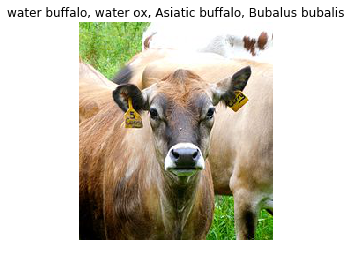

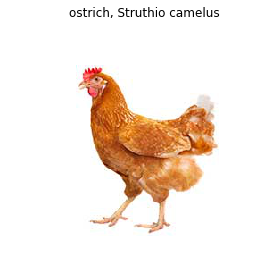

In [33]:
for i, logit in enumerate(logit_probs):
    plt.figure()
    plt.imshow(PIL.Image.open(image_files[i]))
    plt.title(image_classes[np.argmax(logit)])
    plt.axis('off')